In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# 연구용 딥 에이전트

## 개요 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이제 배운 모든 것을 하나로 모을 수 있습니다:

* **TODO**를 사용하여 작업을 추적합니다. 
* 원시 도구 호출 결과를 저장하기 위해 **파일**을 사용합니다. 
* 컨텍스트 격리를 위해 **연구 작업을 하위 에이전트에게 위임**합니다. 

## 검색 도구 

원시 콘텐츠를 파일로 오프로드하고 요약만 에이전트에 반환하는 검색 도구를 구축할 것입니다. 이는 장기 실행 에이전트 궤적의 일반적인 패턴입니다. [Manus에서 보았듯이](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### 핵심 구성 요소

1. **검색 실행 (`run_tavily_search`)**: 결과 수 및 주제 필터링을 위한 구성 가능한 매개변수를 사용하여 Tavily API를 통해 실제 웹 검색을 수행합니다.

2. **콘텐츠 요약 (`summarize_webpage_content`)**: 경량 모델(GPT-4o-mini)을 사용하여 웹페이지 콘텐츠의 구조화된 요약을 생성하여 설명적인 파일 이름과 주요 학습 요약을 모두 생성합니다.

3. **결과 처리 (`process_search_results`)**: HTTP를 통해 전체 웹페이지 콘텐츠를 가져오고, `markdownify`를 사용하여 HTML을 마크다운으로 변환하고, 각 결과에 대한 요약을 생성합니다.

4. **컨텍스트 오프로드 (`tavily_search` 도구)**: 다음을 수행하는 기본 도구:
   - 검색을 실행하고 결과를 처리합니다.
   - 에이전트 상태의 파일에 전체 콘텐츠를 저장합니다(컨텍스트 오프로드).
   - 에이전트에 최소한의 요약만 반환합니다(컨텍스트 스팸 방지).
   - LangGraph `Command`를 사용하여 파일과 메시지를 모두 업데이트합니다.

5. **전략적 사고 (`think_tool`)**: 에이전트가 연구 결과를 분석하고, 격차를 평가하고, 연구 워크플로우의 다음 단계를 계획할 수 있는 구조화된 반영 메커니즘을 제공합니다.

이 아키텍처는 상세한 검색 결과를 파일에 저장하고 에이전트의 작업 컨텍스트를 최소화하고 집중하여 토큰 효율성 문제를 해결합니다.

In [2]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="google_genai:gemini-2.5-flash")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## 딥 에이전트

이제 이전 학습 내용을 모두 적용할 수 있습니다: 

* 연구원에게 `think_tool`과 위에 있는 `search_tool`을 제공할 것입니다.
* 부모 에이전트 파일 도구, `think_tool`, `task` 도구를 제공할 것입니다. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

E0000 00:00:1760675676.967556  540781 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760675676.976442  540781 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

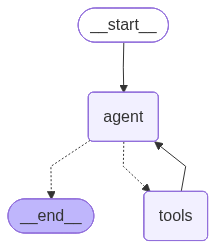

In [6]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Read the search results to gather information about MCP."                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize the gathered information to provide an overview of MCP."                           │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: d1590c7e-2119-4243-873b-7ee771cc2840                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'pending'}, {'content': 'Read the search results to gather information about MCP.', 'status': 'pending'},       │
│ {'content': 'Synthesize the gathered information to provide an overview of MCP.', 'status': 'pending'}]         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: 45e93816-8953-43b6-80c3-dc3409b6b8b7                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Research Model Context Protocol (MCP) using tavily_search. (pending)                                      │
│ 2. ⏳ Read the search results to gather information about MCP. (pending)                                        │
│ 3. ⏳ Synthesize the gathered information to provide an overview of MCP. (pending)                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Read the search results to gather information about MCP."                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize the gathered information to provide an overview of MCP."                           │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: e5aae068-0f01-41ca-bcc2-1f98d3f34ca8                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'in_progress'}, {'content': 'Read the search results to gather information about MCP.', 'status': 'pending'},   │
│ {'content': 'Synthesize the gathered information to provide an overview of MCP.', 'status': 'pending'}]         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP)"                                                                       │
│ }                                                                                                               │
│    ID: 0a1414cc-37e0-459f-978c-dfa45affcedb                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol (MCP)':                                                        │
│                                                                                                                 │
│ - model_context_protocol_overview_ibm_2g7Wk1n-.md: The Model Context Protocol (MCP) is a standardization layer  │
│ enabling AI applications, especially multi-agent systems, to communicate effectively with external services,    │
│ tools, and data sources. This article provides an overview and analysis of MCP, likening it to a USB-C port for │
│ AI. Its primary significance lies in establishing an open standard for AI-tool interactions, addressing         │
│ challenges in tool integration and information dissemination. MCP operates on a client/server model, allowing   │
│ for 'plug-and-play' tool usage, reducing development complexity, and enhancing AI model performance by          │
│ efficiently managing context flow....                                                                           │
│                                                                                                                 │
│ Files: model_context_protocol_overview_ibm_2g7Wk1n-.md                                                          │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: 39ffe358-c173-47f0-9c66-0bd7aae78242                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 Research Model Context Protocol (MCP) using tavily_search. (in_progress)                                  │
│ 2. ⏳ Read the search results to gather information about MCP. (pending)                                        │
│ 3. ⏳ Synthesize the gathered information to provide an overview of MCP. (pending)                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Read the search results to gather information about MCP."                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize the gathered information to provide an overview of MCP."                           │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: a072996f-cea8-4ae6-935b-5876e6b0b1b4                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'completed'}, {'content': 'Read the search results to gather information about MCP.', 'status': 'in_progress'}, │
│ {'content': 'Synthesize the gathered information to provide an overview of MCP.', 'status': 'pending'}]         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "model_context_protocol_overview_ibm_2g7Wk1n-.md"                                                │
│ }                                                                                                               │
│    ID: 951e8df0-5ff1-4274-bd72-58aa69d990ec                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: What is Model Context Protocol (MCP)? - IBM                                            │
│      2                                                                                                          │
│      3  **URL:** https://www.ibm.com/think/topics/model-context-protocol                                        │
│      4  **Query:** Model Context Protocol (MCP)                                                                 │
│      5  **Date:** Fri Oct 17, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  The Model Context Protocol (MCP) is a standardization layer enabling AI applications, especially        │
│ multi-agent systems, to communicate effectively with external services, tools, and data sources. This article   │
│ provides an overview and analysis of MCP, likening it to a USB-C port for AI. Its primary significance lies in  │
│ establishing an open standard for AI-tool interactions, addressing challenges in tool integration and           │
│ information dissemination. MCP operates on a client/server model, allowing for 'plug-and-play' tool usage,      │
│ reducing development complexity, and enhancing AI model performance by efficiently managing context flow.       │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  What is Model Context Protocol (MCP)? | IBM                                                             │
│     12                                                                                                          │
│     13                                                                                                          │
│     14                                                                                                          │
│     15                                                                                                          │
│     16                                                                                                          │
│     17  What is Model Context Protocol (MCP)?                                                                   │
│     18  =====================================                                                                   │
│     19                                                                                                          │
│     20  ![](https://assets.ibm.com/is/image/ibm/ibm_think_projectkavya_twist_still_4k?ts=1746859205539&dpr=off) │
│     21                                                                                                          │
│     22  AI Agents                                                                                               │
│     23                                                                                                          │
│     24  * [Welcome](https://www.ibm.com/think/ai-agents#605511093)                                              │
│     25  * Caret right                                                                                           │
│     26    Introduction                                                                                          │
│     27    + [Overview](https://www.ibm.com/think/topics/ai-agents#7281535)                                      │
│     28    + [AI agents vs AI assistants](https://www.ibm.com/think/topics/ai-agents-vs-ai-assistants#7281536)   │
│     29    + [Agentic AI](https://www.ibm.com/think/topi

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: c37fd8e6-dc4a-40d1-9181-88c7b74149cd                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ✅ Research Model Context Protocol (MCP) using tavily_search. (completed)                                    │
│ 2. 🔄 Read the search results to gather information about MCP. (in_progress)                                    │
│ 3. ⏳ Synthesize the gathered information to provide an overview of MCP. (pending)                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Read the search results to gather information about MCP."                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Synthesize the gathered information to provide an overview of MCP."                           │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 53b37f31-43fb-4756-a0a2-2c98be1c2e5d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'completed'}, {'content': 'Read the search results to gather information about MCP.', 'status': 'completed'},   │
│ {'content': 'Synthesize the gathered information to provide an overview of MCP.', 'status': 'in_progress'}]     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is a standardization layer designed to enable AI applications, particularly    │
│ multi-agent systems, to communicate effectively with external services, tools, and data sources. It aims to     │
│ establish an open standard for AI-tool interactions, addressing challenges in tool integration and information  │
│ dissemination.                                                                                                  │
│                                                                                                                 │
│ Here's an overview of MCP:                                                                                      │
│                                                                                                                 │
│ **Purpose and Analogy:**                                                                                        │
│ *   MCP acts as a "USB-C port for AI," providing a standardized way for AI models to connect with various tools │
│ and data sources.                                                                                               │
│ *   It helps AI agents become context-aware and comply with a standardized protocol for tool integration,       │
│ remedying issues like ineffective information dissemination between specialized agents and errors in tool       │
│ execution or output parsing.                                                                                    │
│                                                                                                                 │
│ **How it Works (Client/Server Model):**                                                                         │
│ MCP operates on a client/server model with three key architectural components:                                  │
│                                                                                                                 │
│ 1.  **MCP Host:** This is the AI application that receives user requests and seeks access to context through    │
│ MCP. It contains the orchestration logic and connects clients to servers. Examples include IDEs like Cursor or  │
│ Claude Desktop.                                                                                                 │
│ 2.  **MCP Client:** This component exists within the host and converts user requests into a structured format   │
│ that the open protocol can process. A single host can have multiple clients, but each client has a 1:1          │
│ relationship with an MCP server. Clients manage sessions (interruptions, timeouts, reconnections, closures),    │
│ parse responses, handle errors, and verify response relevance. Examples include IBM BeeAI, Microsoft Copilot    │
│ Studio, and Claude.ai.                                                                                          │
│ 3.  **MCP Server:** This is the external service that provides context to the LLM by converting user requests   │
│ to server actions. Examples include integrations with Slack, GitHub, Git, Docker, or web search. MCP servers    │
│ expose data through:                                                                                            │
│     *   **Resources:** For information retrieval from internal or external databases without executing          │
│ actionable computations.                                                                                        │
│     *   **Tools:** For information exchange with tools that can perform side effects (e.g., calculations, API   │
│ requests).                                                                                                      │
│     *   **Prompts:** Reusable templates and workflows for LLM-server communication.                             │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'completed'}, {'content': 'Read the search results to gather information about MCP.', 'status': 'completed'},   │
│ {'content': 'Synthesize the gathered information to provide an overview of MCP.', 'status': 'completed'}]       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is a standardization layer designed to enable AI applications, particularly    │
│ multi-agent systems, to communicate effectively with external services, tools, and data sources. It aims to     │
│ establish an open standard for AI-tool interactions, addressing challenges in tool integration and information  │
│ dissemination.                                                                                                  │
│                                                                                                                 │
│ Here's a breakdown of MCP:                                                                                      │
│                                                                                                                 │
│ **Purpose and Analogy:**                                                                                        │
│ *   MCP is likened to a USB-C port for AI, providing a standardized way for various tools and data sources to   │
│ provide context to AI models.                                                                                   │
│ *   It helps AI agents become context-aware and comply with a standardized protocol for tool integration,       │
│ especially in multi-agent systems where information dissemination can be challenging.                           │
│                                                                                                                 │
│ **How it Works (Client/Server Model):**                                                                         │
│ *   MCP operates on a client/server model with three key architectural components:                              │
│     *   **MCP Host:** The AI application that receives user requests and seeks access to context through MCP.   │
│ It contains the orchestration logic and connects clients to servers.                                            │
│     *   **MCP Client:** Resides within the host and converts user requests into a structured format for the     │
│ protocol to process. A single host can have multiple clients, but each client has a 1:1 relationship with an    │
│ MCP server. Clients manage sessions, handle errors, and verify response relevance.                              │
│     *   **MCP Server:** The external service that provides context to the Large Language Model (LLM) by         │
│ converting user requests to server actions. Examples include integrations with Slack, GitHub, Git, Docker, or   │
│ web search. Servers expose data through:                                                                        │
│         *   **Resources:** For information retrieval from databases (return data, no actionable computations).  │
│         *   **Tools:** For information exchange with tools that perform side effects (e.g., calculations, API   │
│ requests).                                                                                                      │
│         *   **Prompts:** Reusable templates and workflows for LLM-server communication.                         │
│                                                                                                                 │
│ **Transport Layer:**                                                                                            │
│ *   The transport layer between clients and servers converts MCP protocol messages into JSON-RPC format for     │
│ two-way communication.                                                                                          │
│ *   Two main transport methods are used:                                                                        │
│     *   **Standard Input/Output (stdio):** Best for integrating local resources (e.g., local file systems,      │
│ databases, APIs) due to simple input/output transmissio

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## 딥 에이전트 패키지 사용

이제 기본 패턴을 이해하셨습니다! 

[ `deepagents` 패키지](https://github.com/hwchase17/deepagents)를 간단한 추상화로 사용할 수 있습니다:

* 파일 시스템 도구가 포함되어 있습니다.
* todo 도구가 포함되어 있습니다.
* 작업 도구가 포함되어 있습니다.

하위 에이전트와 하위 에이전트가 사용할 도구만 제공하면 됩니다.

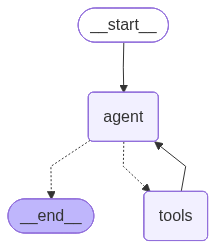

In [8]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Provide a brief overview of MCP based on the research."                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 822aa815-0571-49d0-9b25-7ffa1a164e15                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'pending'}, {'content': 'Provide a brief overview of MCP based on the research.', 'status': 'pending'}]         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Provide a brief overview of MCP based on the research."                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 056d08bc-e6de-4868-8630-556ff67efa3f                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'in_progress'}, {'content': 'Provide a brief overview of MCP based on the research.', 'status': 'pending'}]     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) overview"                                                              │
│ }                                                                                                               │
│    ID: b9f83d4a-3b93-4d4d-93ba-253105232aa6                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol (MCP) overview':                                               │
│                                                                                                                 │
│ - mcp_protocol_overview_mHkaOES1.md: This article provides an overview of the Model Context Protocol (MCP), a   │
│ standardization layer designed to facilitate effective communication between AI applications and external       │
│ services such as tools, databases, and predefined templates. It addresses challenges in multi-agent system      │
│ information dissemination and tool integration by establishing an open standard for AI-tool interactions. Key   │
│ findings include MCP's role in enabling "plug-and-play" tool usage, streamlining integration, and efficiently   │
│ managing context for optimal AI model performance, acting as a crucial integration layer that complements       │
│ existing agent orchestration frameworks....                                                                     │
│                                                                                                                 │
│ Files: mcp_protocol_overview_mHkaOES1.md                                                                        │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research Model Context Protocol (MCP) using tavily_search."                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Provide a brief overview of MCP based on the research."                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 2248fd16-0e45-448e-8748-70aa419b7d55                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) using tavily_search.', 'status':       │
│ 'completed'}, {'content': 'Provide a brief overview of MCP based on the research.', 'status': 'in_progress'}]   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is a standardization layer that enables effective communication between AI     │
│ applications and external services like tools, databases, and templates. It addresses challenges in multi-agent │
│ systems by providing an open standard for AI-tool interactions, allowing for "plug-and-play" tool usage,        │
│ streamlined integration, and efficient context management for optimal AI model performance.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->